In [ ]:
%%capture
!pip install static-frame pyspark 
!pip install --upgrade plotly

In [ ]:
import json
import requests
import static_frame
import numpy as np
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import pyspark
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark import SparkFiles

In [ ]:
# spark session
spark = SparkSession.builder.appName("COVID19-Data-Analysis").getOrCreate()

In [ ]:
!wget https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/jhu/full_data.csv

--2023-01-28 03:51:28--  https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/jhu/full_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15912520 (15M) [text/plain]
Saving to: ‘full_data.csv’

full_data.csv       100%[===================>]  15.17M  --.-KB/s    in 0.1s    

2023-01-28 03:51:28 (118 MB/s) - ‘full_data.csv’ saved [15912520/15912520]



In [ ]:
!wget https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv

--2023-01-28 03:51:32--  https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11438357 (11M) [text/plain]
Saving to: ‘vaccinations.csv’

vaccinations.csv    100%[===================>]  10.91M  --.-KB/s    in 0.1s    

2023-01-28 03:51:32 (111 MB/s) - ‘vaccinations.csv’ saved [11438357/11438357]



In [ ]:
case_df = spark.read.csv("full_data.csv", header=True, inferSchema=True)

In [ ]:
case_df.count()

238644

In [ ]:
new_cases_df = case_df.sort(['date'],ascending=[False])

In [ ]:
new_cases_df = new_cases_df[new_cases_df['date']>='2022-12-01']

In [ ]:
new_cases_df.show()

+-------------------+----------------+---------+----------+-----------+------------+------------+-------------+--------------+---------------+
|               date|        location|new_cases|new_deaths|total_cases|total_deaths|weekly_cases|weekly_deaths|biweekly_cases|biweekly_deaths|
+-------------------+----------------+---------+----------+-----------+------------+------------+-------------+--------------+---------------+
|2023-01-26 00:00:00|Papua New Guinea|      0.0|       0.0|    46663.0|       669.0|         0.0|          0.0|           0.0|            0.0|
|2023-01-26 00:00:00|          Serbia|   2331.0|      15.0|  2467970.0|     17681.0|      4797.0|         46.0|       10656.0|           97.0|
|2023-01-26 00:00:00|        Paraguay|     null|      null|   805486.0|     19778.0|        null|         null|          null|           null|
|2023-01-26 00:00:00|           Nauru|      0.0|       0.0|     4621.0|         1.0|         0.0|          0.0|           0.0|            0.0|

In [ ]:
vaccine_df = spark.read.csv("vaccinations.csv", header=True, inferSchema=True)
vaccine_df.count()

152381

In [ ]:
new_vaccine_df = vaccine_df.sort(['date'],ascending=[False])
new_vaccine_df = new_vaccine_df[new_vaccine_df['date']>='2022-12-01']

In [ ]:
new_vaccine_df.show()

+-------------------+--------+-------------------+------------------+-----------------+-----------------------+--------------+----------------------+------------------+------------------------------+-----------------------------+-----------------------------------+--------------------------+------------------------------+-----------------------+-----------------------------------+
|           location|iso_code|               date|total_vaccinations|people_vaccinated|people_fully_vaccinated|total_boosters|daily_vaccinations_raw|daily_vaccinations|total_vaccinations_per_hundred|people_vaccinated_per_hundred|people_fully_vaccinated_per_hundred|total_boosters_per_hundred|daily_vaccinations_per_million|daily_people_vaccinated|daily_people_vaccinated_per_hundred|
+-------------------+--------+-------------------+------------------+-----------------+-----------------------+--------------+----------------------+------------------+------------------------------+-----------------------------+---

In [ ]:
inner_df = new_vaccine_df.join(new_cases_df, [new_vaccine_df.date == new_cases_df.date, new_vaccine_df.location == new_cases_df.location], how= "inner").drop(new_cases_df['date']).drop(new_cases_df['location'])
inner_df = inner_df.sort(['total_vaccinations'],ascending=[False])
inner_df.show(80)

+--------+--------+-------------------+------------------+-----------------+-----------------------+--------------+----------------------+------------------+------------------------------+-----------------------------+-----------------------------------+--------------------------+------------------------------+-----------------------+-----------------------------------+---------+----------+------------+------------+------------+-------------+--------------+---------------+
|location|iso_code|               date|total_vaccinations|people_vaccinated|people_fully_vaccinated|total_boosters|daily_vaccinations_raw|daily_vaccinations|total_vaccinations_per_hundred|people_vaccinated_per_hundred|people_fully_vaccinated_per_hundred|total_boosters_per_hundred|daily_vaccinations_per_million|daily_people_vaccinated|daily_people_vaccinated_per_hundred|new_cases|new_deaths| total_cases|total_deaths|weekly_cases|weekly_deaths|biweekly_cases|biweekly_deaths|
+--------+--------+-------------------+-----

In [ ]:
inner_df = inner_df.toPandas()

In [ ]:
temp_data = inner_df.filter(["date", "location", "total_cases", "total_deaths","total_vaccinations"])

In [ ]:
temp_data

,date,location,total_cases,total_deaths,total_vaccinations
0,2023-01-26,World,669752300.0,6820723.0,1.324569e+10
1,2023-01-25,World,669472344.0,6816703.0,1.324524e+10
2,2023-01-24,World,669180291.0,6814501.0,1.324398e+10
3,2023-01-23,World,668910603.0,6812550.0,1.324333e+10
4,2023-01-22,World,668741630.0,6811114.0,1.324299e+10
...,...,...,...,...,...
6893,2022-12-08,Romania,3298738.0,67289.0,NaN
6894,2022-12-04,Sao Tome and Principe,6278.0,77.0,NaN
6895,2022-12-06,Tanzania,40806.0,845.0,NaN
6896,2022-12-21,Uzbekistan,249045.0,1637.0,NaN


In [ ]:
total_cases_per_country = temp_data['total_cases'].groupby(temp_data['location'])
# total_cases_per_country
print(total_cases_per_country.groups.keys())
groups = list()
total_vaccines_per_country = temp_data['total_vaccinations'].groupby(temp_data['location'])
total_deaths_per_country = temp_data['total_deaths'].groupby(temp_data['location'])

i = 0
for g, data in total_cases_per_country:
    groups.append([g,data.mean(),0,0])
    i+=1

i = 0
for g, data in total_vaccines_per_country:
    groups[i][3]=data.mean()
    i+=1

i = 0
for g, data in total_deaths_per_country:
    groups[i][2]=data.mean()
    i+=1
print(groups)
df = pd.DataFrame(groups)

print(df)



dict_keys(['Afghanistan', 'Africa', 'Albania', 'Andorra', 'Angola', 'Anguilla', 'Argentina', 'Aruba', 'Asia', 'Australia', 'Austria', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Botswana', 'Brazil', 'Bulgaria', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cayman Islands', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Cook Islands', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Democratic Republic of Congo', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt', 'Estonia', 'Eswatini', 'Europe', 'European Union', 'Fiji', 'Finland', 'France', 'Germany', 'Ghana', 'Gibraltar', 'Greece', 'Guatemala', 'Guinea', 'Guyana', 'Haiti', 'High income', 'Honduras', 'Hong Kong', 'Hungary', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Kazakhstan', 'Kenya', 'Kosovo', 'Kuwait', 'Kyrgyzstan', 'Lebanon', 'Lesotho', 'Liberia', 'Libya', 'Liechtenstein', 'Lithuania', 'Low inc

In [ ]:
df = df[df[0]!="World"]

df = df[df[0]!="Asia"]
df = df[df[0]!="Africa"]

df = df[df[0]!="North America"]

df = df[df[0]!="South America"]
df = df[df[0]!="Europe"]
df = df[df[0]!="Lower middle income"]
df = df[df[0]!="Upper middle income"]
df = df[df[0]!="High income"]


In [ ]:
df

,0,1,2,3
0,Afghanistan,2.072944e+05,7847.320755,1.251141e+07
2,Albania,3.336575e+05,3594.589744,3.034212e+06
3,Andorra,4.741478e+04,157.666667,1.562420e+05
4,Angola,1.049028e+05,1927.031250,2.368751e+07
5,Anguilla,3.904000e+03,12.000000,2.445750e+04
...,...,...,...,...
154,Venezuela,5.482176e+05,5830.125000,3.786099e+07
155,Vietnam,1.152286e+07,43181.813953,2.652584e+08
156,Wallis and Futuna,3.419667e+03,7.000000,1.805800e+04
158,Yemen,1.194500e+04,2159.000000,1.240972e+06


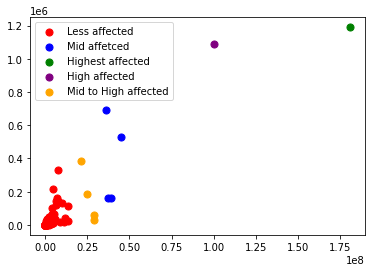

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt

Z1 = AgglomerativeClustering(n_clusters=5, linkage='average')
df = df.dropna()
X = df.iloc[:, [1, 2]].values
Z1.fit_predict(df.iloc[:,[1,2]])

sum0 = 0
sum1 = 0
sum2 = 0
sum3 = 0
sum4 = 0
labels = Z1.labels_
# print(X)
# print(labels)
for i in range(len(Z1.labels_)):
  if(Z1.labels_[i]==0):
    sum0+=df.iloc[i,1]
    # print("Country 0 : "+df.iloc[i,0])
  elif(Z1.labels_[i]==1):
    sum1+=df.iloc[i,1]
    # print("Country 1 : "+df.iloc[i,0])
  elif(Z1.labels_[i]==2):
    sum2+=df.iloc[i,1]
    # print("Country 2 : "+df.iloc[i,0])
  elif(Z1.labels_[i]==3):
    sum3+=df.iloc[i,1]
    # print("Country 3 : "+df.iloc[i,0])
  else:
    sum4+=df.iloc[i,1]
    # print("Country 4 : "+df.iloc[i,0])


plt.scatter(X[labels==0, 0], X[labels==0, 1], s=50, marker='o', color='red')
plt.scatter(X[labels==1, 0], X[labels==1, 1], s=50, marker='o', color='blue')
plt.scatter(X[labels==2, 0], X[labels==2, 1], s=50, marker='o', color='green')
plt.scatter(X[labels==3, 0], X[labels==3, 1], s=50, marker='o', color='purple')
plt.scatter(X[labels==4, 0], X[labels==4, 1], s=50, marker='o', color='orange')
plt.legend(["Less affected" , "Mid affetced", "Highest affected", "High affected", "Mid to High affected"])
plt.show()

221707892.30419812 157121975.70676693 181035096.15789473 100378398.58333333


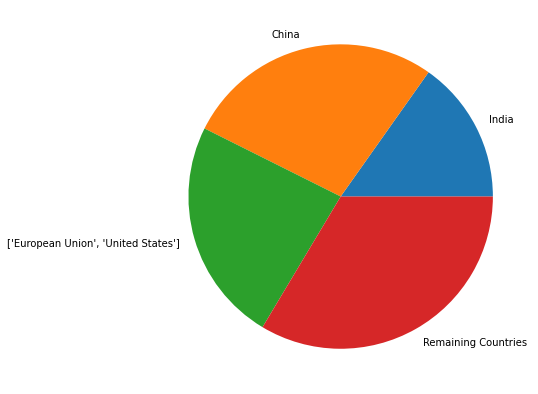

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
 
countries = ["India", "China", ["European Union", "United States"], "Remaining Countries"]

print(sum0, sum1, sum2, sum3)
data = [sum3,sum2,sum1,sum0]
# Creating plot
fig = plt.figure(figsize =(10, 7))
plt.pie(data, labels = countries)
 
# show plot
plt.show()

In [ ]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df.rename(columns = {0:'Country', 1:'Total_cases',2:'Total_deaths',3:'Vaccines'}, inplace = True)
df

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,Country,Total_cases,Total_deaths,Vaccines
0,Afghanistan,2.072944e+05,7847.320755,1.251141e+07
2,Albania,3.336575e+05,3594.589744,3.034212e+06
3,Andorra,4.741478e+04,157.666667,1.562420e+05
4,Angola,1.049028e+05,1927.031250,2.368751e+07
5,Anguilla,3.904000e+03,12.000000,2.445750e+04
...,...,...,...,...
154,Venezuela,5.482176e+05,5830.125000,3.786099e+07
155,Vietnam,1.152286e+07,43181.813953,2.652584e+08
156,Wallis and Futuna,3.419667e+03,7.000000,1.805800e+04
158,Yemen,1.194500e+04,2159.000000,1.240972e+06


In [ ]:

train  = pd.DataFrame(columns = ['Country','Total_cases','Total_deaths','Vaccines'])
test = pd.DataFrame(columns = ['Country','Total_cases','Total_deaths','Vaccines'])

for i in range(len(df)):
#   if(df.iloc[i,0]=="India"):
#     test = test.append({'Country' : df.iloc[i,0], 'Total_cases' : df.iloc[i,1], 'Total_deaths' : df.iloc[i,2],'Vaccines' : df.iloc[i,3]}, ignore_index = True)
#   elif(df.iloc[i,0]=="China"):
#     test = test.append({'Country' : df.iloc[i,0], 'Total_cases' : df.iloc[i,1], 'Total_deaths' : df.iloc[i,2],'Vaccines' : df.iloc[i,3]}, ignore_index = True)
  if(df.iloc[i,0]=="European Union"):
    test = test.append({'Country' : df.iloc[i,0], 'Total_cases' : df.iloc[i,1], 'Total_deaths' : df.iloc[i,2],'Vaccines' : df.iloc[i,3]}, ignore_index = True)
  elif(df.iloc[i,0]=="Brazil"):
    test = test.append({'Country' : df.iloc[i,0], 'Total_cases' : df.iloc[i,1], 'Total_deaths' : df.iloc[i,2],'Vaccines' : df.iloc[i,3]}, ignore_index = True)
  elif(df.iloc[i,0]=="Russia"):
    test = test.append({'Country' : df.iloc[i,0], 'Total_cases' : df.iloc[i,1], 'Total_deaths' : df.iloc[i,2],'Vaccines' : df.iloc[i,3]}, ignore_index = True)
  elif(df.iloc[i,0]=="United States"):
    test = test.append({'Country' : df.iloc[i,0], 'Total_cases' : df.iloc[i,1], 'Total_deaths' : df.iloc[i,2],'Vaccines' : df.iloc[i,3]}, ignore_index = True)
  elif(df.iloc[i,0]=="Nepal"):
    test = test.append({'Country' : df.iloc[i,0], 'Total_cases' : df.iloc[i,1], 'Total_deaths' : df.iloc[i,2],'Vaccines' : df.iloc[i,3]}, ignore_index = True)
  elif(df.iloc[i,0]=="New Zealand"):
    test = test.append({'Country' : df.iloc[i,0], 'Total_cases' : df.iloc[i,1], 'Total_deaths' : df.iloc[i,2],'Vaccines' : df.iloc[i,3]}, ignore_index = True)
  else:
    train = train.append({'Country' : df.iloc[i,0], 'Total_cases' : df.iloc[i,1], 'Total_deaths' : df.iloc[i,2],'Vaccines' : df.iloc[i,3]}, ignore_index = True)
  


In [ ]:
test

,Country,Total_cases,Total_deaths,Vaccines
0,Brazil,3.616479e+07,6.933471e+05,4.802056e+08
1,European Union,1.810351e+08,1.190272e+06,9.324098e+08
2,Nepal,1.000975e+06,1.201923e+04,6.045874e+07
3,New Zealand,2.050452e+06,2.288366e+03,1.194165e+07
4,Russia,2.144414e+07,3.854542e+05,1.835687e+08
5,United States,1.003784e+08,1.090730e+06,6.638576e+08


In [ ]:
train

,Country,Total_cases,Total_deaths,Vaccines
0,Afghanistan,2.072944e+05,7847.320755,1.251141e+07
1,Albania,3.336575e+05,3594.589744,3.034212e+06
2,Andorra,4.741478e+04,157.666667,1.562420e+05
3,Angola,1.049028e+05,1927.031250,2.368751e+07
4,Anguilla,3.904000e+03,12.000000,2.445750e+04
...,...,...,...,...
137,Venezuela,5.482176e+05,5830.125000,3.786099e+07
138,Vietnam,1.152286e+07,43181.813953,2.652584e+08
139,Wallis and Futuna,3.419667e+03,7.000000,1.805800e+04
140,Yemen,1.194500e+04,2159.000000,1.240972e+06


In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error,r2_score
model = ElasticNet(alpha=1.0, l1_ratio=0.5)
model.fit(train.iloc[:,[1,2]],train.iloc[:,3])
y_pred_elastic = model.predict(test.iloc[:,[1,2]])
print(y_pred_elastic)
print(np.sqrt(mean_squared_error(test.iloc[:,3],y_pred_elastic)))

[1.51149723e+09 3.13812484e+09 4.17481166e+07 2.79758792e+07
 8.52758649e+08 2.57205345e+09]
1292179995.463483


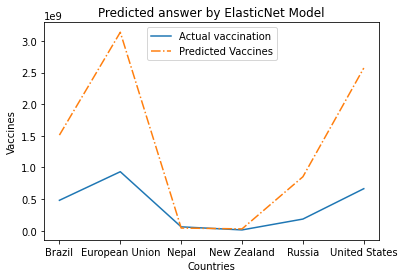

In [ ]:
# from pandas.core.arrays.datetimes import DataFrame
#plotting the graphs of actuals and precited vaccines by out model
temp_1 = test.iloc[:, [-1]].values.tolist()
temp = test.iloc[:, [0]].values.tolist()
temp_1 = np.floor(temp_1)
temp_2 = y_pred_elastic
# print(temp_1)
# print(temp_2)
x=['Brazil','European Union','Nepal','New Zealand','Russia','United States']
# x=['Nepal','New Zealand']
# print(x)

plt.plot(x, temp_1, label='temp_1')
plt.plot(x, temp_2, '-.', label='temp_2')

plt.xlabel("Countries")
plt.ylabel("Vaccines")
plt.title('Predicted answer by ElasticNet Model')
plt.legend(['Actual vaccination', 'Predicted Vaccines'], loc='upper center')
plt.show()
# print(temp)

In [ ]:
import numpy as np


y_pred = [1.5, 3.13, 0.0417, 0.0279, 0.852, 2.57]
y_true = [0.48, 1.03, 0.0604, 0.0190, 1.830, 0.63]
# error = rmse(y_true, y_pred)
error = np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))
print("RMSE:", error)

RMSE: 1.3019800881733945


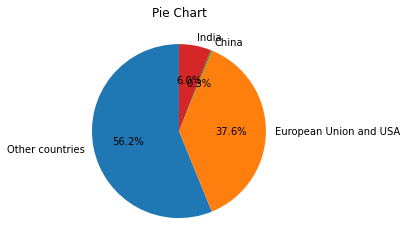

In [ ]:
import matplotlib.pyplot as plt

# Data to be represented
data = [419022409.58, 280365850.9913, 1894773.95, 44677914.46341463]

# Labels for the sections of the pie chart
labels = ['Other countries', 'European Union and USA','China', 'India']

# Plot the pie chart
plt.pie(data, labels=labels, autopct='%1.1f%%', startangle=90)

# Add a title
plt.title("Pie Chart")

# Show the plot
plt.show()


[44677914.46, 1894773.95, 280365850.991, 419022409.58]


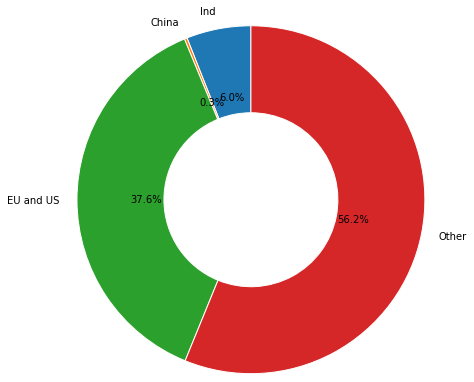

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

countries = ["India", "China", ["European Union", "United States"], "Remaining Countries"]

# print(sum0, sum1, sum2, sum3)
# data = [sum3,sum2,sum1,sum0]
# Data to be represented
data = [419022409.58, 280365850.991, 1894773.95, 44677914.46]
data.reverse()
print(data)
# Labels for the sections of the pie chart
labels = ["Ind", "China", "EU and US", "Other"]

# Plot the doughnut chart
fig, ax = plt.subplots()
ax.pie(data, labels=labels, autopct='%1.1f%%', startangle=90, 
       radius=2, wedgeprops=dict(width=1, edgecolor='w'))

# Add a circular center hole
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

# Add a title
# plt.title("Doughnut Chart")

# Show the plot
plt.show()


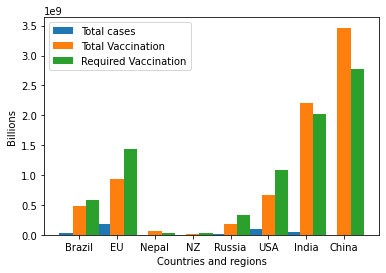

In [ ]:
import matplotlib.pyplot as plt

# Data to plot
labels = ['Brazil', 'EU', 'Nepal', 'NZ', 'Russia', 'USA','India','China']
values1 = [3.616479e+07	, 1.810351e+08, 1.000975e+06, 2.050452e+06, 2.144414e+07, 1.003784e+08, 44678370, 1903578]
# values2 = [6.933471e+05, 1.190272e+06, 1.201923e+04, 2.288366e+03, 3.854542e+05, 1.090730e+06, 2,20,04,28,000,]
values3 = [4.802056e+08,9.324098e+08,6.045874e+07,1.194165e+07,1.835687e+08,6.638576e+08,2200428000,3465459000]
values4 = [588945391,1433513500,34288504,25082031,339267017,1077072800,2016682600,2771339200]
# Create the bar chart
bar_width = 0.35
x_pos = [i for i in range(len(labels))]

fig, ax = plt.subplots()
rects1 = ax.bar(x_pos, values1, bar_width, label='Total cases')
# rects2 = ax.bar([x + bar_width for x in x_pos], values2, bar_width, label='Values 2')
rects3 = ax.bar([x + bar_width for x in x_pos], values3, bar_width, label='Total Vaccination')
rects4 = ax.bar([x + bar_width * 2 for x in x_pos], values4, bar_width, label='Required Vaccination')

# Add x-axis labels
ax.set_xticks([x + bar_width for x in x_pos])
ax.set_xticklabels(labels)

# Add title and labels
# plt.title("Bar Chart with Four Labels on X-axis")
plt.xlabel("Countries and regions")
plt.ylabel("Billions")

# Add legend
plt.legend()

# Show plot
plt.show()
